# imports and functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.losses import MAE

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score,  r2_score, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

import joblib

In [ ]:
def show(df):
  df['Rating'].plot(kind='hist', bins=20, title='Rating')
  plt.gca().spines[['top', 'right',]].set_visible(False)
  df.info()

In [ ]:
def custom_accuracy(y_true, y_pred):
    tolerance = 0.5
    return np.mean(np.abs(y_true - y_pred) <= tolerance)

In [ ]:
def predict_review_rating(review_text, tok_name, model_name):
    tokenizer = joblib.load(f'{tok_name}.pkl')
    model = load_model(f'{model_name}.h5', custom_objects={'mse': metrics.MeanSquaredError})

    review_sequence = tokenizer.texts_to_sequences([review_text])
    review_padded = pad_sequences(review_sequence, maxlen=500)

    predicted_rating = model.predict(review_padded)
    return round(predicted_rating[0][0], 2)

In [ ]:
#tokenization with our own solution (for research topic)

class SimpleTokenizer:
    def __init__(self, num_words=None):
        self.num_words = num_words
        self.word_index = {}
        self.index_word = {}

    def fit_on_texts(self, texts):
        word_counts = defaultdict(int)
        for text in texts:
            for word in text.split():
                word_counts[word] += 1

        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        if self.num_words:
            sorted_words = sorted_words[:self.num_words - 1]

        self.word_index = {word: i + 1 for i, (word, _) in enumerate(sorted_words)}
        self.index_word = {i: word for word, i in self.word_index.items()}

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequences.append([self.word_index.get(word, 0) for word in text.split()])
        return sequences

    def pad_sequences(self, sequences, maxlen):
        padded_sequences = np.zeros((len(sequences), maxlen), dtype=int)
        for i, seq in enumerate(sequences):
            if len(seq) > maxlen:
                padded_sequences[i, :] = seq[:maxlen]
            else:
                padded_sequences[i, -len(seq):] = seq
        return padded_sequences

# Benchmark models




In [ ]:
def run(data, tok_name = 'tokenizer', model_name = 'model', save = False):
  tokenizer = Tokenizer(num_words=5000)
  tokenizer.fit_on_texts(data['Review'])
  X = tokenizer.texts_to_sequences(data['Review'])
  X = pad_sequences(X, maxlen=500)
  y = data['Rating'].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  model = Sequential()
  model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='linear'))

  model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mae'])
  history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

  y_pred = model.predict(X_test).flatten()

  y_test_classes = np.digitize(y_test, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]) - 1
  y_pred_classes = np.digitize(y_pred, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]) - 1

  f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
  mae = mean_absolute_error(y_test, y_pred)

  loss, accuracy, mae_evaluate = model.evaluate(X_test, y_test)
  acc = custom_accuracy(y_test, y_pred)
  print('1 - benchmark')
  print(f'MAE on Test Set: {mae}')
  print(f'MAE_ev on Test Set: {mae_evaluate}')
  print(f'Accuracy on Test Set: {accuracy}')
  print(f'F1 Score on Test Set: {f1:.2f}')
  print(f'Custom Accuracy (within tolerance): {acc * 100:.2f}%')

  if save:
    joblib.dump(tokenizer, f'{tok_name}.pkl')
    model.save(f'{model_name}.h5')

In [ ]:
def run2(data, tok_name='tokenizer', model_name='model', save=False):
    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    tokenizer.fit_on_texts(data['Review'])
    X = tokenizer.texts_to_sequences(data['Review'])
    X = pad_sequences(X, maxlen=500)
    y = data['Rating'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        LSTM(64, dropout=0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mae', metrics=['accuracy','mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred = model.predict(X_test).flatten()

    y_test_classes = np.digitize(y_test, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]) - 1
    y_pred_classes = np.digitize(y_pred, bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]) - 1

    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)

    loss, accuracy, mae_evaluate = model.evaluate(X_test, y_test)
    acc = custom_accuracy(y_test, y_pred)
    print('2 - benchmark')
    print(f'MAE on Test Set: {mae}')
    print(f'MAE_ev on Test Set: {mae_evaluate}')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')
    print(f'Custom Accuracy (within tolerance): {acc * 100:.2f}%')

    if save:
      joblib.dump(tokenizer, f'{tok_name}.pkl')
      model.save(f'{model_name}.h5')

    return model, history


#Benchmark models with integer outputs

In [ ]:
def run_int(data, tok_name='tokenizer', model_name='model', save=False):
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(data['Review'])
    X = tokenizer.texts_to_sequences(data['Review'])
    X = pad_sequences(X, maxlen=500)
    y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1)

    y_pred_classes = np.argmax(model.predict(X_test), axis=1)

    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    accuracy = accuracy_score(y_test, y_pred_classes)
    print('1 na int')
    print(f'F1 Score on Test Set: {f1:.2f}')
    print(f'Accuracy on Test Set: {accuracy:.2f}')

    if save:
        joblib.dump(tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')


In [ ]:
def run2_int(data, tok_name='tokenizer', model_name='model', save=False):
    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    tokenizer.fit_on_texts(data['Review'])
    X = tokenizer.texts_to_sequences(data['Review'])
    X = pad_sequences(X, maxlen=500)

    y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        LSTM(64, dropout=0.2),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('2 na int')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


In [ ]:
def run2_bi(data, tok_name='tokenizer', model_name='model', save=False):
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(data['Review'])
    X = tokenizer.texts_to_sequences(data['Review'])
    X = pad_sequences(X, maxlen=500)

    y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
      Embedding(input_dim=10000, output_dim=128, input_length=500),
      Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)),
      LSTM(64, dropout=0.2),
      Dense(64, activation='relu'),
      Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('Bi')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


# GRU

In [ ]:
def run2_gru(data, tok_name='tokenizer', model_name='model', save=False):

    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    tokenizer.fit_on_texts(data['Review'])
    X = tokenizer.texts_to_sequences(data['Review'])
    X = pad_sequences(X, maxlen=500)


    y = data['Rating'].values - 1


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        GRU(128, dropout=0.2),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])


    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('GRU')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


# CNN + RNN hybrid

In [ ]:
def run2_cnn_rnn(data, tok_name='tokenizer', model_name='model', save=False):

    tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
    tokenizer.fit_on_texts(data['Review'])
    X = tokenizer.texts_to_sequences(data['Review'])
    X = pad_sequences(X, maxlen=500)

    y = data['Rating'].values - 1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=500),
        Conv1D(128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        LSTM(64, dropout=0.2, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=20, batch_size=64,
        validation_split=0.1,
        callbacks=[early_stop]
    )

    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('cnn+rnn')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(tokenizer, f'{tok_name}.pkl')
        model.save(f'{model_name}.h5')

    return model, history


#SVC

In [ ]:
def run2_svm(data, vectorizer_name='tfidf_vectorizer', model_name='svm_model', save=False):

    reviews = data['Review'].tolist()
    ratings = data['Rating'].values - 1

    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(reviews).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, ratings, test_size=0.2, random_state=42)

    model = SVC(kernel='linear', C=1, probability=True)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print('SVC')
    print(f'Accuracy on Test Set: {accuracy}')
    print(f'F1 Score on Test Set: {f1:.2f}')

    if save:
        joblib.dump(vectorizer, f'{vectorizer_name}.pkl')
        joblib.dump(model, f'{model_name}.pkl')

    return model, vectorizer


# LogisticRegression

In [ ]:
def run_logistic_regression(data, target_col='Rating', text_col='Review', save=False, model_name='logistic_model'):

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data[target_col])

    X_train, X_test, y_train, y_test = train_test_split(
        data[text_col], y, test_size=0.2, random_state=42
    )

    pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=5000, stop_words='english')),
        ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("run_logistic_regression")
    print(f'Accuracy: {acc}')
    print(f'F1 Score: {f1:.2f}')
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    if save:
        joblib.dump(pipeline, f'{model_name}.pkl')
        joblib.dump(label_encoder, f'{model_name}_label_encoder.pkl')

    return pipeline, label_encoder


# run all

In [ ]:
df = pd.read_csv('/content/temp4.csv')

In [ ]:
sampled_data = (
    df.groupby('Rating', group_keys=False)
    .apply(lambda x: x.sample(n=3000, random_state=42) if len(x) >= 3000 else x)
)

<ipython-input-6-9a4fffe4ca1c>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=3000, random_state=42) if len(x) >= 3000 else x)


<class 'pandas.core.frame.DataFrame'>
Index: 28885 entries, 4 to 24390
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  28885 non-null  int64  
 1   Unnamed: 0    23355 non-null  float64
 2   Title         22053 non-null  object 
 3   URL           22053 non-null  object 
 4   Review        28885 non-null  object 
 5   Rating        28885 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.5+ MB


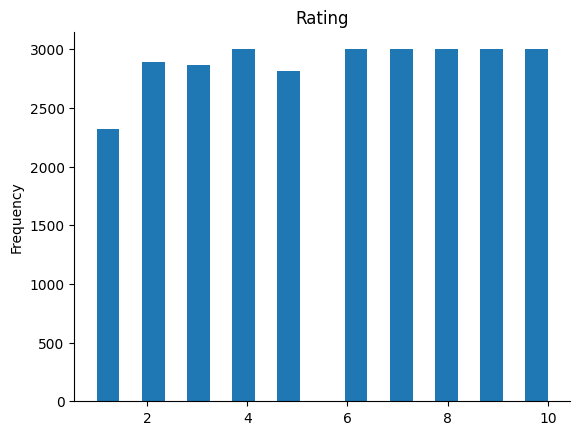

In [ ]:
show(sampled_data)

In [ ]:
run(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 214s 649ms/step - accuracy: 0.0702 - loss: 12.7801 - mae: 2.9039 - val_accuracy: 0.0775 - val_loss: 4.4447 - val_mae: 1.6861
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 209s 644ms/step - accuracy: 0.0807 - loss: 3.8672 - mae: 1.5686 - val_accuracy: 0.0775 - val_loss: 3.0964 - val_mae: 1.3910
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 260s 639ms/step - accuracy: 0.0803 - loss: 2.6283 - mae: 1.2850 - val_accuracy: 0.0775 - val_loss: 2.7163 - val_mae: 1.2986
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.0730 - loss: 2.9429 - mae: 1.3573
1 - benchmark
MAE on Test Set: 1.350948469210026
MAE_ev on Test Set: 1.3509485721588135
Accuracy on Test Set: 0.07564479857683182
F1 Score on Test Set: 0.21
Custom Accuracy (within tolerance): 22.88%


In [ ]:
run2(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 207s 627ms/step - accuracy: 0.0726 - loss: 2.8655 - mae: 2.8655 - val_accuracy: 0.0775 - val_loss: 1.7444 - val_mae: 1.7444
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 205s 630ms/step - accuracy: 0.0872 - loss: 1.5241 - mae: 1.5241 - val_accuracy: 0.0775 - val_loss: 1.3460 - val_mae: 1.3460
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 260s 624ms/step - accuracy: 0.0843 - loss: 1.2328 - mae: 1.2328 - val_accuracy: 0.0775 - val_loss: 1.2938 - val_mae: 1.2938
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 204s 628ms/step - accuracy: 0.0808 - loss: 1.0988 - mae: 1.0988 - val_accuracy: 0.0775 - val_loss: 1.2358 - val_mae: 1.2358
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 262s 628ms/step - accuracy: 0.0793 - loss: 0.9810 - mae: 0.9810 - val_accuracy: 0.0775 - val_loss: 1.2158 - val_mae: 1.2158
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 266s 642ms/step - accuracy: 0.0865 - loss: 0.9101 - mae: 0.9101 - val_accuracy: 0.0775 - val_loss: 1.2082 - val_mae: 1.2082
Epoch 7/20
325/325 ━━━━━━━━

(<Sequential name=sequential_9, built=True>,
 <keras.src.callbacks.history.History at 0x78fca07eece0>)

In [ ]:
run_int(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 213s 649ms/step - accuracy: 0.1676 - loss: 2.1619 - val_accuracy: 0.2627 - val_loss: 1.8241
Epoch 2/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 211s 649ms/step - accuracy: 0.3016 - loss: 1.7474 - val_accuracy: 0.3289 - val_loss: 1.7128
Epoch 3/3
325/325 ━━━━━━━━━━━━━━━━━━━━ 261s 643ms/step - accuracy: 0.3820 - loss: 1.5694 - val_accuracy: 0.3531 - val_loss: 1.6447
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step
1 na int
F1 Score on Test Set: 0.33
Accuracy on Test Set: 0.34


In [ ]:
run2_int(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 205s 622ms/step - accuracy: 0.1534 - loss: 2.1881 - val_accuracy: 0.2523 - val_loss: 1.8542
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 263s 623ms/step - accuracy: 0.2966 - loss: 1.7334 - val_accuracy: 0.2717 - val_loss: 1.7521
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 263s 629ms/step - accuracy: 0.3517 - loss: 1.5812 - val_accuracy: 0.3367 - val_loss: 1.6608
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 264s 635ms/step - accuracy: 0.4222 - loss: 1.4244 - val_accuracy: 0.3527 - val_loss: 1.6886
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 257s 621ms/step - accuracy: 0.4784 - loss: 1.2763 - val_accuracy: 0.3890 - val_loss: 1.6510
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 201s 618ms/step - accuracy: 0.5388 - loss: 1.1644 - val_accuracy: 0.3868 - val_loss: 1.6845
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 202s 621ms/step - accuracy: 0.5626 - loss: 1.1028 - val_accuracy: 0.3959 - val_loss: 1.7334
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 201s 617ms/step - accuracy: 0.6201 - loss: 0.97

(<Sequential name=sequential_11, built=True>,
 <keras.src.callbacks.history.History at 0x78fca07ffca0>)

In [ ]:
run2_bi(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


325/325 ━━━━━━━━━━━━━━━━━━━━ 1109s 3s/step - accuracy: 0.1657 - loss: 2.1370 - val_accuracy: 0.2761 - val_loss: 1.7827
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1166s 3s/step - accuracy: 0.3348 - loss: 1.6116 - val_accuracy: 0.2873 - val_loss: 1.7409
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1116s 3s/step - accuracy: 0.4064 - loss: 1.4265 - val_accuracy: 0.3271 - val_loss: 1.7178
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1113s 3s/step - accuracy: 0.4845 - loss: 1.2640 - val_accuracy: 0.3315 - val_loss: 1.8139
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1167s 3s/step - accuracy: 0.5376 - loss: 1.1349 - val_accuracy: 0.3739 - val_loss: 1.8107
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1115s 3s/step - accuracy: 0.5867 - loss: 1.0103 - val_accuracy: 0.3583 - val_loss: 1.9302
181/181 ━━━━━━━━━━━━━━━━━━━━ 127s 694ms/step
Bi
Accuracy on Test Set: 0.34066124285961574
F1 Score on Test Set: 0.33


(<Sequential name=sequential, built=True>,
 <keras.src.callbacks.history.History at 0x7eab0419fc10>)

In [ ]:
run2_gru(sampled_data, "tokenizer_clean", "model_clean", False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 463s 1s/step - accuracy: 0.1448 - loss: 2.2022 - val_accuracy: 0.2852 - val_loss: 1.7893
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 504s 1s/step - accuracy: 0.2967 - loss: 1.7251 - val_accuracy: 0.3120 - val_loss: 1.7481
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.4027 - loss: 1.5040 - val_accuracy: 0.3388 - val_loss: 1.6413
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.4932 - loss: 1.2993 - val_accuracy: 0.3527 - val_loss: 1.6726
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - accuracy: 0.5507 - loss: 1.1547 - val_accuracy: 0.3682 - val_loss: 1.6995
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.6205 - loss: 1.0136 - val_accuracy: 0.3756 - val_loss: 1.7705
181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 144ms/step
GRU
Accuracy on Test Set: 0.3410074433096763
F1 Score on Test Set: 0.33


(<Sequential name=sequential_1, built=True>,
 <keras.src.callbacks.history.History at 0x7eaa6ed974c0>)

In [ ]:
run2_cnn_rnn(sampled_data, "tokenizer_clean", "model_clean", False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 72s 610ms/step - accuracy: 0.1017 - loss: 2.2986 - val_accuracy: 0.1750 - val_loss: 2.1235
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 81s 600ms/step - accuracy: 0.1942 - loss: 2.0056 - val_accuracy: 0.2125 - val_loss: 1.8621
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 80s 582ms/step - accuracy: 0.2958 - loss: 1.6860 - val_accuracy: 0.2800 - val_loss: 1.8270
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 68s 604ms/step - accuracy: 0.3707 - loss: 1.4829 - val_accuracy: 0.2587 - val_loss: 1.8663
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 582ms/step - accuracy: 0.4557 - loss: 1.3092 - val_accuracy: 0.2775 - val_loss: 1.9840
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 83s 590ms/step - accuracy: 0.5299 - loss: 1.1747 - val_accuracy: 0.2763 - val_loss: 2.1484
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 83s 602ms/step - accuracy: 0.5490 - loss: 1.0857 - val_accuracy: 0.2713 - val_loss: 2.4133
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 588ms/step - accuracy: 0.6053 - loss: 0.9571 - val

(<Sequential name=sequential_1, built=True>,
 <keras.src.callbacks.history.History at 0x7b009e82cd60>)

In [ ]:
run2_svm(sampled_data, "tokenizer_clean", "model_clean", False)

Accuracy on Test Set: 0.2925
F1 Score on Test Set: 0.29


(SVC(C=1, kernel='linear', probability=True),
 TfidfVectorizer(max_features=5000, stop_words='english'))

In [ ]:
pipeline, label_encoder = run_logistic_regression(sampled_data, save = True,  model_name='logistic_model_pl')

run_logistic_regression
Accuracy: 0.38462870001731003
F1 Score: 0.38

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78       437
           1       0.69      0.75      0.72       566
           2       0.47      0.45      0.46       562
           3       0.43      0.40      0.42       635
           4       0.32      0.30      0.31       594
           5       0.26      0.26      0.26       612
           6       0.17      0.19      0.18       565
           7       0.21      0.20      0.21       618
           8       0.27      0.25      0.26       612
           9       0.34      0.35      0.35       576

    accuracy                           0.38      5777
   macro avg       0.39      0.40      0.39      5777
weighted avg       0.38      0.38      0.38      5777

